# Modelos Lineales - Parte 1. Regresión

<h1>Índice<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Distribución-de-los-parámetros" data-toc-modified-id="Distribución-de-los-parámetros-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Distribución de los parámetros</a></span><ul class="toc-item"><li><span><a href="#Prior-de-los-parámetros" data-toc-modified-id="Prior-de-los-parámetros-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prior de los parámetros</a></span></li><li><span><a href="#Máximo-a-posteriori-(MAP)" data-toc-modified-id="Máximo-a-posteriori-(MAP)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Máximo a posteriori (MAP)</a></span></li><li><span><a href="#Distribución-posterior" data-toc-modified-id="Distribución-posterior-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Distribución posterior</a></span></li><li><span><a href="#¿Por-qué-distribuciones-normales?" data-toc-modified-id="¿Por-qué-distribuciones-normales?-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>¿Por qué distribuciones normales?</a></span></li></ul></li><li><span><a href="#Distribición-predictiva" data-toc-modified-id="Distribición-predictiva-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Distribición predictiva</a></span><ul class="toc-item"><li><span><a href="#Predicciones-semi-bayesianas" data-toc-modified-id="Predicciones-semi-bayesianas-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Predicciones semi-bayesianas</a></span></li><li><span><a href="#La-función-predictiva-posterior" data-toc-modified-id="La-función-predictiva-posterior-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>La función predictiva posterior</a></span></li><li><span><a href="#Ejemplo" data-toc-modified-id="Ejemplo-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Ejemplo</a></span></li></ul></li></ul></div>

Arrancamos con una celda preparatoria, como de costumbre.

In [319]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "05_ModelosLineales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Regresión lineal bayesiana.

Hasta ahora, nuestro acercamiento a la regresión lineal se centró en encontrar los parámetros que minimizaban una determinada función de error.

En el caso de 1) errores normales, 2) independientes, 3) con la misma varianza, vimos que esa función de error correspondía al logaritmo de la verosimilitud, y que los parámetros que encontrábamos eran estimadores de máxima verosimilitud, que tienen una serie de propiedades muy buenas.

La maximización de la verosimilitud tiene un límite, sin embargo: la complejidad (y flexibilidad) del modelo no puede ser muy grande, porque si no, el modelo tiende a ajustar. Hay que *elegir*, entonces, la complejidad del modelo, teniendo en cuenta el conjunto de datos disponible. Vimos que dejar de lado un conjunto de validación (o hacer CV) puede ayudarnos a tomar esta decisión de manera criteriosa.

Por otro lado, vimos que podemos modificar la función de error agregando un término de regularización, y controlar la complejidad efectiva del modelo a través de un nuevo hiperparámetro. En este caso, sin embargo, no es trivial encontrar una función de verosimilitud asociada con la función a minimizar.

## Distribución de los parámetros

$\newcommand{\vv}[1]{\boldsymbol{#1}}$
$\newcommand{\om}[0]{\boldsymbol{\omega}}$
$\newcommand{\norm}[0]{\mathcal{N}}$
$\newcommand{\b}[1]{\mathrm{\mathbf{#1}}}$
$\newcommand{\T}{^\mathrm{T}}$

En la visión bayesiana, los parámetros del modelo también tienen distribuciones de probabilidad, que nos indican nuestro grado de conocimiento del valor de ese parámetro.

Para empezar con el *approach* bayesiano, lo primero que tenemos que hacer es decidir un prior para los parámetros.

Pero primero, recordemos que, en general, el objetivo de la regresión es encontrar los parámetros $\vv{\omega}$ de la distribución *condicional* $p(t | x, \om, \beta)$. Desde el primer momento, hicimos una suposición <font size=5>enorme</font>:

$$
p(t | x, \om, \beta) = \norm(t| y(x, \om), \beta^{-1})\;\;.
$$

Es decir, que la distribución condicional de los targets es una normal, centrada en la predicción del modelo, $y(x, \om)$, que puede expresarse, en el caso de modelos lineales, como:

$$
y(x, \om) = \sum_{j=0}^M \omega_j \phi_j(x)\;\;,
$$

donde supusimos $\phi_0(x) = 1$. Esta sumatoria puede expresarse de manera vectorial, definiendo el vector de las funciones de base, $\boldsymbol{\phi} = (\phi_0, \ldots, \phi_M)\T$, y el de los parámetros, $\om = (\omega_0, \ldots, \omega_M)\T$:

$$
y(x, \om) = \om\T \boldsymbol{\phi}(x)\;\;.
$$

Con todo esto, encontramos los valores de los parámetros que maximizaban la verosimilitud, $\vv{\om}_\mathrm{ML}$ y $\beta_\mathrm{ML}$:

$$
\om_\mathrm{ML} = (\boldsymbol{\Phi}\T \boldsymbol{\Phi})^{-1}\,\boldsymbol{\Phi}\T\,\b{t}
$$

$$
\frac{1}{\beta_{ML}} = \frac{1}{N}\sum_{i=1}^N\left\{y(x_i, \boldsymbol{\omega}_{ML}) - t_i\right\}^2\;\;,
$$

donde $\boldsymbol{\Phi}$ es la *matriz de diseño*, cuya fila $i$-ésima es simplemente $\boldsymbol{\phi}(x_i)$.

En la filosofía bayesiana, esto es solo parte de la historia. 

### Prior de los parámetros

Fijemos un prior para los parámetros. Como la verosimilitud es normal, una elección natural (y simple) es elegir priors normales para $\om$:

$$
p(\om | \gamma) = \norm(\om | 0, \gamma^{-1}\mathrm{\mathbf{I}})\;\;,
$$
que depende de un único hiperparámetro escalar, $\gamma$ que define la precisión de los parámetros (la inversa de la varianza.

En el ejemplo del ajuste polinomial, con grado $M$ (en realidad, siempre que haya $M$ funciones de base más un parámetro de sesgo $\omega_0$) esto es:

$$
p(\om | \gamma) = \left(\frac{\gamma}{2\pi}\right)^{(M+1)/2} \exp{\left\{-\frac{\gamma}{2}\om^T\om\right\}}\;\;.
$$

### Máximo a posteriori (MAP)

Para encontrar la distribución posterior de los parámetros, usamos el teorema de Bayes.

$$
p(\om | \b{t}, \beta, \gamma) = \frac{p(\b{t} | \om, \beta, \gamma)\,p(\om | \gamma)}{p(\b{t} | \beta, \gamma)}\;\;,
$$ 

donde escribí de forma explícita todos los elementos condicionales (los datos, $\b{t}$ --recordemos que cada $t_i$ siempre viene asociado con un $x_i$, que ya no escribo para no abundar--, y los hiperparámetros $\beta$ y $\gamma$). Recuerde que el numerador es una constante con respecto a $\om$, de manera que podemos obviarla para buscar la maximización de la posterior.

Entonces, tenemos

$$
p(\om | \b{t}, \beta, \gamma) \propto p(\b{t} | \om, \beta, \gamma)\,p(\om | \gamma)\;\;.
$$ 

En este punto ponemos nuestras decisiones de prior y de verosimilitud:

$$
p(\om | \b{t}, \beta, \gamma) \propto \prod_{i=1}^N \norm(t_i| y(x_i, \om), \beta^{-1})\; \left(\frac{\gamma}{2\pi}\right)^{(M+1)/2} \exp{\left\{-\frac{\gamma}{2}\om^T\om\right\}}\;\;.
$$

Como de costumbre, es más fácil maximizar el logaritmo de la posterior:

$$
\ln p(\om | \b{t}, \beta, \gamma) = -\frac{\beta}{2}\sum_{i=1}^N \left\{t_i - \om\T\boldsymbol{\phi}(x_i)\right\}^2 - \frac{\gamma}{2}\om\T\om + \text{const}\;\;,
$$

que es equivalente a la función de error de la regresión *ridge*, con $\lambda = \gamma/\beta$. O sea, que (con esta elección de verosimilitud y prior), encontramos naturalmente una regresión regularizada. Entonces, siguiendo la misma línea de razonamiento que en su momento, obtenemos que el vector de parámetros que maximiza el valor de la distribución posterior es:

$$
\om_\mathrm{MAP} = \left(\frac{\gamma}{\beta}\mathrm{\mathbf{I}} + \boldsymbol{\Phi}\T \boldsymbol{\Phi}\right)^{-1}\,\boldsymbol{\Phi}\T\,\b{t}
$$

***
**Una nota**. Otra vez vemos que el problema del sobreajuste está íntimamente vinculado con la búsqueda de maximizar la verosimilitud. Es lo mismo que pasaba con la moneda: si hacemos tres tiradas y sacamos caras en todas, podemos calcular, via ML, que $\mu=1$, y el conjunto de entrenamiento (tres caras) estará perfectamente ajustado, pero el modelo va a fallar de forma miserable con datos que no haya visto antes. En cambio, si vemos la posterior de $\mu$, encontramos que existe posibilidad de obtener ceca en tiradas ulteriores.
***

Con otras elecciones de prior, podemos llegar a Lasso u otro tipo de regularizaciones (ver ec. 3.56 del [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)).

### Distribución posterior

Ya tenemos el valor que maximiza la posterior. Pero, ¿cómo es la distribución posterior completa? 

Para encontrar esto, usamos el hecho de que la distribución normal es el prior conjugado para una verosimilitud normal (si suponemos conocida la matriz de precisión, $\beta$). Por lo tanto, la posterior también será una distribución multinormal.

$$
p(\om | \b{t}, \beta, \gamma) = \norm(\om | \mathbf{m}_N, \mathbf{S}_N)\;\;,
$$

donde $\mathbf{m}_N$ y $\mathbf{S}_N$ son el vector de valores medios y la matriz de covarianza, respectivamente, y el subíndice hace alusión al tamaño de los datos tenidos en cuenta.

Para el prior que elegimos arriba, 

$$
p(\om | \gamma) = \norm(\om | \mathbf{0}, \gamma^{-1} \mathbf{I}) = \left(\frac{\gamma}{2\pi}\right)^{(M+1)/2} \exp{\left\{-\frac{\gamma}{2}\om^T\om\right\}}\;\;,
$$

obtenemos, usando propiedades de la distribución normal, que:

$$
\boxed{\begin{array}{lll}
\mathbf{m}_N &=& \beta\;\mathbf{S}_N \boldsymbol{\Phi}\T \b{t}\\
\mathbf{S}^{-1}_N &=& \gamma\;\mathbf{I} + \beta\;\boldsymbol{\Phi}\T \boldsymbol{\Phi}\;\;.
\end{array}}
$$

Noten que si metemos el resultado de $\mathbf{S}_N$ en al ecuación de la media, recuperamos la ecuación de arriba para $\om_\mathrm{MAP}$. Esto es razonable, como la normal es simétrica, el valor que maximiza la posterior es también el valor medio.

En un ejercicio vamos a ver cómo pueden usarse estas fórmulas para un aprendizaje secuencial de la posterior. Acá, veamos cómo se compara lo que sale de acá con los estimadores de máxima verosimilitud que vimos para la ordenada al origen ($\omega_0$) y pendiente ($\omega_1$) de una regresión lineal hace unas clases (la visión frecuentista).

Si tenemos un modelo lineal, $y(x, \om) = \omega_0 + \omega_1\,x$, la matriz de diseño y su transpuesta son

$$
\boldsymbol{\Phi} = \begin{pmatrix}
                    1 & x_1\\
                    1 & x_2\\
                    \vdots& \vdots\\
                    1 & x_N\\\end{pmatrix}
$$                    

$$
\boldsymbol{\Phi}^T = \begin{pmatrix}
                    1 & 1 & \cdots & 1\\
                    x_1 & x_2 & \cdots & x_N\\
   \end{pmatrix}\;\;.
$$

Entonces, la matriz de precisión queda

$$
\boldsymbol{S}_N^{-1} = \beta \begin{pmatrix}N + \gamma/\beta & N\bar{x}\\
                                       N\bar{x} & \sum_i x_i^2 + \gamma/\beta
\end{pmatrix}
$$

si tenemos un prior que se va ensanchando hasta el infinito: es decir, que no tenemos prior, y en términos matemáticos, $\gamma \rightarrow 0$, queda

$$
\boldsymbol{S}_N^{-1} = N\beta \begin{pmatrix}1 & \bar{x}\\
                                       \bar{x} & \frac{1}{N}\sum_i x_i^2
\end{pmatrix}\;\;,
$$

que es la misma expresión que teníamos para la covarianza de los estimadores de ML.

***

Pensemos ahora en prior más general (pero siempre normal):

$$
p(\om | \mathbf{m}_0, \mathbf{S}_0) = \norm(\om | \mathbf{m}_0, \mathbf{S}_0)\;\;,
$$

donde ahora la matiz de covarianza es general. Entre otras cosas, esto permite acomodar constantes de regularización diferentes para cada parámetro, que fue una pregunta de hace unas clases; además, podemos pensar en una matriz no diagonal, mucho más flexible. 

Como sea, el valor medio y matriz de precisión de la posterior en este caso es:

$$
\boxed{\begin{array}{lll}
\mathbf{m}_N &=& \mathbf{S}_N\; \left(\mathbf{S}^{-1}_0 \mathbf{m}_0 + \beta\;\boldsymbol{\Phi}\T \b{t}\right)\\
\mathbf{S}^{-1}_N &=& \mathbf{S}^{-1}_0 + \beta\;\boldsymbol{\Phi}\T \boldsymbol{\Phi}\;\;.
\end{array}}
$$

Con esto, tenemos una descripción completa de la distribución del vector de parámetros $\om\T = (\omega_0, \ldots, \omega_M)$. 

### ¿Por qué distribuciones normales?

A esta altura del partido, es lícito preguntarse por qué estamos insistiendo tanto con las distribuciones normales, y dándole un rol tan central.

Las razones son múltiples, pero una de las más potentes es posiblemente el Teorema Central del Límite (ver  [el notebook correspondiente](06a_TeoremaCentralLimite.ipynb)) y las diapositivas de la clase de hoy.

## Distribición predictiva

Hace un tiempo hablamos de la prevalencia de la visión predictiva vs. la visión inferencista o explicativa. De forma que todo lo de arriba, referido a los parámetros solo es una parte de la visión bayesiana, relacionada con cómo encontrar los mejores parámetros y su distribución.

Si queremos hacer predicciones, tenemos dos caminos: la forma semi-bayesiana, en la que fijamos los valores de los parámetros al valor MAP, o la forma *fully bayesian* en la que usamos la regla del producto y de la suma de forma sistemática.

### Predicciones semi-bayesianas

En este approach, la predicción consiste en tomar la verosimilitud y evaluarla en el valor MAP del vector de parámetros $\om$:

$$
p(t | x, \om_\mathrm{MAP}, \beta) = \norm(t| y(x, \om_\mathrm{MAP}), \beta^{-1})\;\;,
$$

donde, recordemos, suponemos que $\beta$ es conocida (ya vamos a ver cómo se puede *inferir* en esta visión). Con esta distribución, las predicciones sobre $t$ tienen naturaleza probabilística, como queda más o menos claro en esta figura del Bishop:

<img width=400px src="images/Figure1.16.png">

### La función predictiva posterior

Sin embargo, haber fijado el parámetro $\om$ a un valor, cuando en realidad contamos con toda su distribución (la posterior, $p(\om | \b{t})$) no es totalmente bayesiano. Mi abuela decía que fijar parámetros hace llorar al niño Bayes.

Entonces, ¿cómo hacemos para tener en cuenta *toda* la información disponible a la hora de hacer predicciones? ¿Cómo hacemos para ser completamente bayesianos.

Primero, pensemos qué es lo que queremos realmente. 

***
**Pregunta**: ¿Alguna idea? ¿Qué es predecir?

¿Les parece razonable pensar que queremos saber cómo será la distribución de una nueva medición $t^\prime$, pero una vez que hayamos considerado los datos ya obtenidos, $\b{t}$?

Y si es así, ¿cómo escribo eso? ¡¿Y cómo lo calculo?!
***

El objetivo, entonces, es encontrar

$$
p(t^\prime | \b{t}, \beta, \gamma)\;\;,
$$

donde condicioné a los valores de los hiperparámetros. Mal no puede hacer.

Así escrito esto no lo sé calcular, pero podemos escribir la distribución conjunta con una variable extra, y usar la regla de la suma para marginalizar:

$$
p(t^\prime | \b{t}, \beta, \gamma) = \int p(t^\prime, \om | \b{t}, \beta, \gamma)\;\mathrm{d}\om\;\;.
$$

En otras palabras, marginalizo sobre $\om$. Ahora, el integrando puedo expresarlo de una manera más simpática, usando la regla del producto:

$$
p(t^\prime, \om | \b{t}, \beta, \gamma) = p(t^\prime | \om, \b{t}, \beta, \gamma)\;p(\om | \b{t}, \beta, \gamma)\;\;.
$$

Veamos los dos términos. En el primero, como estamos condicionando con respecto a $\om$, la distribución de $t^\prime$ se vuelve independiente de $\b{t}$ (estamos usando fuertemente la hipótesis de independencia). Entonces, el primer término es $p(t^\prime | \om, \beta, \gamma)$, donde reconocemos a la verosimilitud de un dato (es independiente de $\gamma$):

$$
p(t^\prime | \om, \beta) = \norm(t^\prime| y(x, \om), \beta^{-1})\;\;.
$$

El segundo término, $p(\om | \b{t}, \beta, \gamma)$ no es ni más ni menos que la posterior del vector de parámetros.

Podemos entonces interpretar a la integral de arriba como el valor medio de la verosimilitud con respecto a la distribución posterior de $\om$

***
**Recordatorio**. El valor medio de una función $f(x)$ con respecto a la función de distribución $p(x)$ es

$$
<f(x)>_{p(x)} = \int f(x)\,p(x)\;\mathrm{d}x\;\;.
$$
***

Gracias a algunas propiedades adicionales de las distribuiones normales, podemos resolver analíticamente la integral que da lugar a la posterior predictiva:

$$
p(t^\prime | \b{t}, \beta, \gamma) = \norm(t^\prime | \mathbf{m}_N\T \boldsymbol{\phi}(x), \sigma_N^2)\;\;,
$$

donde la variaza es
$$
\sigma_N^2 = \frac{1}{\beta} + \boldsymbol{\phi}(x)\T \mathbf{S}_N \boldsymbol{\phi}(x)\;\;,
$$
que consiste en una contribución debida a la incertidumbre en los parámetros, y otra que viene de la incerteza de los datos.

### Ejemplo

Veamos esto en acción con nuestro ya conocido dataset sinusoidal.

In [354]:
# Array para plotear
xx = np.linspace(0, 1, 100).reshape([-1, 1])

def plot_data_sine(x, t, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, t, 'ob', mfc='None', ms=10)
    ax.plot(xx, np.sin(2*np.pi * xx), 'g-', lw=2, alpha=0.7, label='Ground Truth')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.legend(loc=0)
    return

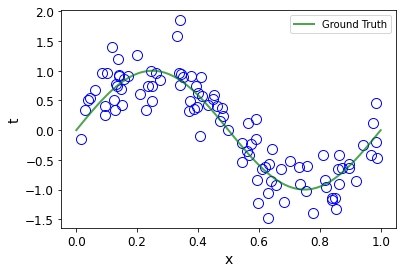

In [355]:
np.random.seed(123456)

# Nuevo set de datos (esta vez, hago dos copias)
x_ = np.random.rand(100, 1)

# Si quieren elegir a mano los valores de x
# x_ = np.array([0.2, 0.8]).reshape((-1, 1))

t_ = np.sin(2*np.pi*x_) + np.random.randn(len(x_), 1) * 0.3

plot_data_sine(x_, t_)

In [418]:
# Fijemos los hiperparámetros
beta = 1/0.3
gamma = 1e-2 / 0.3 # gamma/beta = lambda 

# Number of points to use
n = 2
ii = np.arange(len(x_))
np.random.shuffle(ii)
ii = ii[:n]

**Elección de las funciones de base**

Una parte importante del modelado es elegir las funciones de base con las que vamos a intentar describir los datos.

Acá dejo dos opciones:

* funciones de base polinomiales, como las que ya vimos varias veces.
* funciones de base normales (ver ec. 3.4 del Bishop)

***
**Ejercicio**. Pueden divertirse codeando nuevas funciones de base (¡les prometo que es divertido!), como la sigmoidal (ver ec. 3.5 de Bishop), o la propuesta de Manu de funciones de base periódicas. Piensen y evalúen cuántos hiperparámetros tiene cada elección de funciones de base y qué característica del modelo controla.
***


In [412]:
## Features polinomiales

# Escribamos la matriz de diseño para polinomios de grado 5
from sklearn.preprocessing import PolynomialFeatures

polfeat = PolynomialFeatures(degree=4)
phi = polfeat.fit_transform(x_[ii])

# Necesito también la "matriz de diseño" del vector xx
phi_ = polfeat.transform(xx)

print('Dimensiones de la matriz de diseño: {}'.format(phi.shape))

Dimensiones de la matriz de diseño: (2, 5)


In [421]:
## Gaussian features

mu = np.linspace(0.1, 0.9, 10)
s2 = 0.05
phi = np.ones((len(x_[ii]), len(mu)+1))
phi_ = np.ones((len(xx), len(mu)+1))

for j, m in enumerate(mu):
    phi[:, j+1] = np.exp(-(x_[ii].flatten() - m)**2 / s2)
    phi_[:, j+1] = np.exp(-(xx.flatten() - m)**2 / s2)
    
print('Dimensiones de la matriz de diseño: {}'.format(phi.shape))

Dimensiones de la matriz de diseño: (2, 11)


Recordamos los parámetros para la posterior de los parámetros $\om$:

$$
\boxed{\begin{array}{lll}
\mathbf{m}_N &=& \beta\;\mathbf{S}_N \boldsymbol{\Phi}\T \b{t}\\
\mathbf{S}^{-1}_N &=& \gamma\;\mathbf{I} + \beta\;\boldsymbol{\Phi}\T \boldsymbol{\Phi}\;\;.
\end{array}}
$$


In [422]:
# Escribamos la ecuación para la inversa de la covarianza del posterior
sn_inv = gamma*np.eye(phi.shape[1]) + beta * np.dot(phi.T, phi)

# Calculemos phiT t
tt_ = np.dot(phi.T, t_[ii])

# Y ahora usemos solve para resolver la ecuación sn_inv * x = tt_ --> x = sn * tt_
m_n = beta * np.linalg.solve(sn_inv, tt_)

print('Los valores medios de la posterior de los parámetros son: \n{}'.format(m_n.T))

Los valores medios de la posterior de los parámetros son: 
[[ 0.08289836  0.21117203  0.18733331  0.10130547 -0.00553241 -0.09060352
  -0.12698749 -0.11196624 -0.06991266 -0.03162368 -0.01041347]]


(-3.0, 3.0)

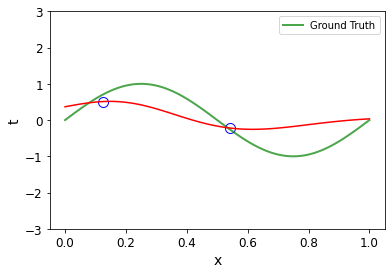

In [423]:
# Podemos plotear la predicción semi-bayesiana
y = np.dot(phi_, m_n)

plot_data_sine(x_[ii], t_[ii])
plt.plot(xx, y, '-r')
plt.ylim(-3, 3)

Encontremos ahora los parámetros de la posterior predictiva

$$
p(t^\prime | \b{t}, \beta, \gamma) = \norm(t^\prime | \mathbf{m}_N\T \boldsymbol{\phi}(x), \sigma_N^2)\;\;,
$$

donde la variaza es
$$
\sigma_N^2 = \frac{1}{\beta} + \boldsymbol{\phi}(x)\T \mathbf{S}_N \boldsymbol{\phi}(x)\;\;,
$$

In [424]:
# Busco la media en los 100 puntos que voy a usar para plotear
# El vactor phi es la transpuesta de la matriz de diseño
mean = np.dot(m_n.T, phi_.T)
sigma2 = np.dot(np.dot(phi_, np.linalg.inv(sn_inv)), phi_.T) + 1/beta

# Me quedo solo con la diagonal para los errores puntuales
err = np.sqrt(np.diag(sigma2))

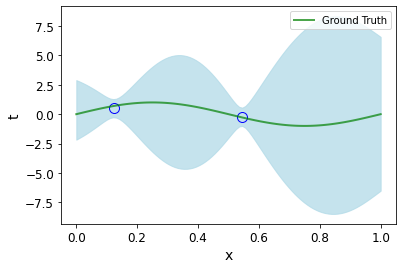

In [425]:
plot_data_sine(x_[ii], t_[ii])

ax = plt.gca()
plt.fill_between(xx.flatten(), mean.flatten() + err, mean.flatten() - err, color='LightBlue', alpha=0.7)
# ax.set_ylim(-5, 5)

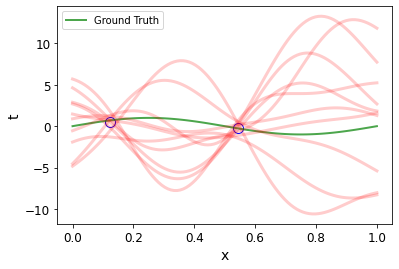

In [426]:
# También podemos obtener muestras de la multinormal
import scipy.stats as st
X = np.random.multivariate_normal(mean.flatten(), sigma2, 10)

plot_data_sine(x_[ii], t_[ii])

for pp in X:
    plt.plot(xx.flatten(), pp, color='r', alpha=0.2, lw=3)
    
ax = plt.gca()
# ax.set_ylim(-5, 5)

***
**Ejercicio**. Exploren el efecto de cambiar las funciones de base, sus hiperparámetros, la cantidad de puntos usados para el entrenamiento, su ubicación en el eje $x$, la constante de regularización (es decir, el prior de los parámetros), etc.
***